In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import time
import pandas as pd


from src.mixtures.nmv_mixture import NormalMeanVarianceMixtures
from src.generators.nmv_generator import NMVGenerator
from src.estimators.semiparametric.nmv_semiparametric_estimator import NMVSemiParametricEstimator

In [9]:
REAL_MU = 2.0
SAMPLE_SIZES = [200, 500, 1000, 5000]
NUM_SIMULATIONS = 1000

MIXING_DISTRIBUTION = gamma(a=2, scale=1.5)

ESTIMATOR_PARAMS_MU = {
    "m": 10,
    "tolerance": 1e-5,
}

In [10]:
def generate_nmvm_samples(real_mu: float, n: int, mixing_dist) -> np.ndarray:
    mixture = NormalMeanVarianceMixtures("canonical", alpha=0, mu=real_mu, distribution=mixing_dist)
    generator = NMVGenerator()
    sample = generator.canonical_generate(mixture, n)
    return sample

In [12]:
results_mu = {n: [] for n in SAMPLE_SIZES}
simulation_stats_mu = {n: {} for n in SAMPLE_SIZES}

start_time_total = time.time()


estimator = NMVSemiParametricEstimator("mu_estimation", ESTIMATOR_PARAMS_MU)

for n in SAMPLE_SIZES:
    estimates_mu_list = []
    start_time_n = time.time()

    for i in range(NUM_SIMULATIONS):
        sample = generate_nmvm_samples(REAL_MU, n, MIXING_DISTRIBUTION)

        estimate_result = estimator.estimate(sample)
        estimates_mu_list.append(estimate_result.value)


    results_mu[n] = np.array(estimates_mu_list)

    stats_n_mu = {'MAE': np.nan, 'MSE': np.nan, 'Std': np.nan}
    if len(estimates_mu_list) > 0:
        valid_estimates = np.array(estimates_mu_list)
        stats_n_mu['MAE'] = np.mean(np.abs(valid_estimates - REAL_MU))
        stats_n_mu['MSE'] = np.mean((valid_estimates - REAL_MU)**2)
        stats_n_mu['Std'] = np.std(valid_estimates)

    simulation_stats_mu[n] = stats_n_mu
    end_time_n = time.time()
    print(f"n = {n}. Время: {end_time_n - start_time_n:.2f} сек.")

n = 200. Время: 5.54 сек.
n = 500. Время: 14.79 сек.
n = 1000. Время: 29.15 сек.
n = 5000. Время: 185.60 сек.


In [13]:
stats_list_mu_df = []
for n in SAMPLE_SIZES:
    stats = simulation_stats_mu[n]
    stats_list_mu_df.append({
        'n': n,
        'MAE': f"{stats['MAE']:.4f}",
        'MSE': f"{stats['MSE']:.4f}",
        'Std Dev': f"{stats['Std']:.4f}",
    })

df_stats_mu = pd.DataFrame(stats_list_mu_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(df_stats_mu.to_string(index=False))

   n    MAE    MSE Std Dev
 200 1.8741 9.4513  2.6054
 500 0.7969 1.9534  1.2631
1000 0.4228 0.3680  0.5555
5000 0.1616 0.0425  0.2001


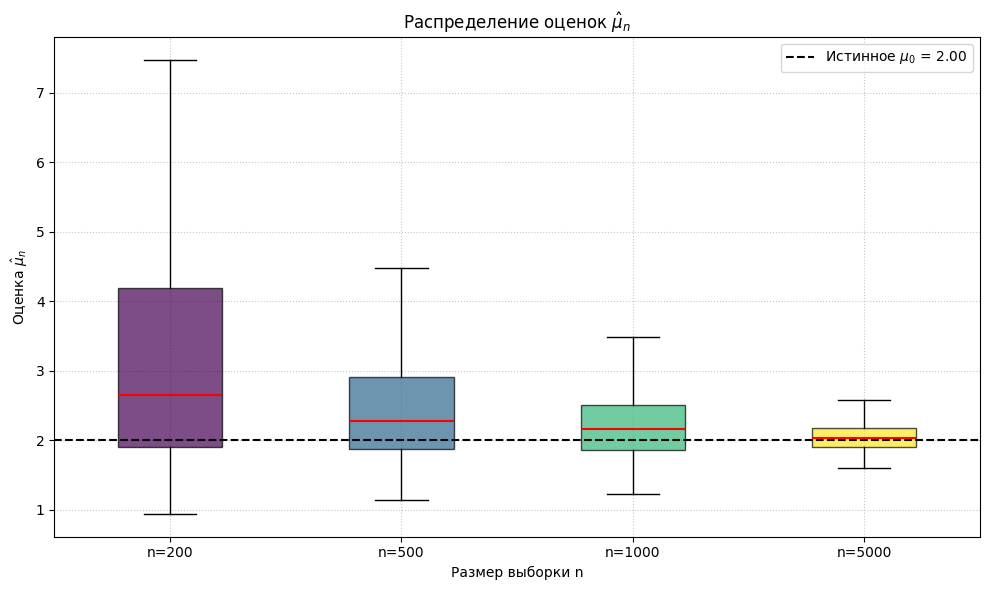

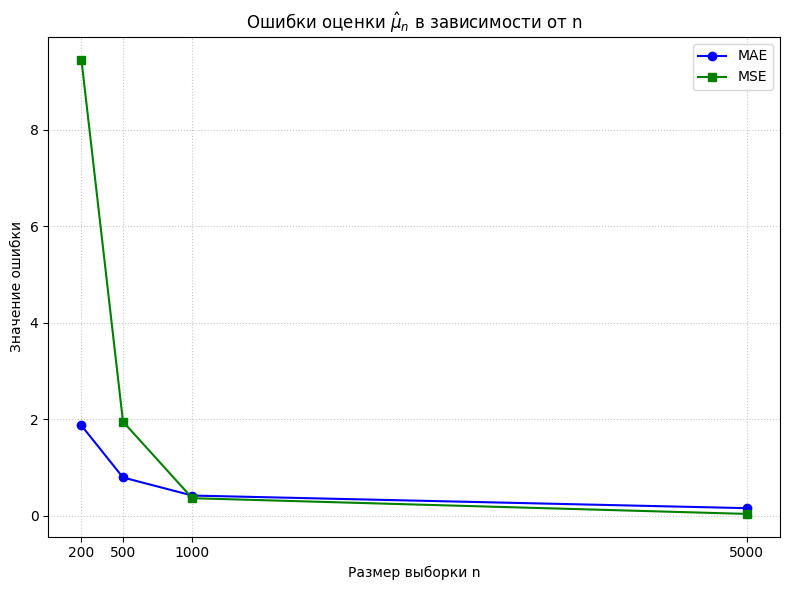

In [14]:
fig1, ax1 = plt.subplots(figsize=(10, 6)) 

data_for_boxplot = [results_mu[n] for n in SAMPLE_SIZES if len(results_mu[n]) > 0]
labels_boxplot = [f'n={n}' for n in SAMPLE_SIZES if len(results_mu[n]) > 0]
positions_boxplot = [i for i, n in enumerate(SAMPLE_SIZES) if len(results_mu[n]) > 0]

bp = ax1.boxplot(data_for_boxplot, positions=positions_boxplot, labels=labels_boxplot,
                    patch_artist=True, showfliers=False, medianprops={'color': 'red', 'linewidth': 1.5})
colors = plt.cm.viridis(np.linspace(0, 1, len(data_for_boxplot)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.axhline(REAL_MU, color='black', linestyle='--', linewidth=1.5, label=f'Истинное $\mu_0$ = {REAL_MU:.2f}')
ax1.set_title('Распределение оценок $\hat{\mu}_n$')
ax1.set_xlabel('Размер выборки n')
ax1.set_ylabel('Оценка $\hat{\mu}_n$')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()
ax1.set_xticks(positions_boxplot)
ax1.set_xticklabels(labels_boxplot)
fig1.tight_layout()
# plt.savefig('validation_mu_boxplot.png', dpi=300)


fig2, ax2 = plt.subplots(figsize=(8, 6)) 

maes = [simulation_stats_mu[n]['MAE'] for n in SAMPLE_SIZES]
mses = [simulation_stats_mu[n]['MSE'] for n in SAMPLE_SIZES]

valid_mae_indices = [i for i, m in enumerate(maes) if not np.isnan(m)]
valid_mse_indices = [i for i, m in enumerate(mses) if not np.isnan(m)]
valid_n_mae = [SAMPLE_SIZES[i] for i in valid_mae_indices]
valid_n_mse = [SAMPLE_SIZES[i] for i in valid_mse_indices]
valid_maes = [maes[i] for i in valid_mae_indices]
valid_mses = [mses[i] for i in valid_mse_indices]


if valid_maes:
    ax2.plot(valid_n_mae, valid_maes, marker='o', linestyle='-', color='blue', label='MAE')
if valid_mses:
    ax2.plot(valid_n_mse, valid_mses, marker='s', linestyle='-', color='green', label='MSE')

if not valid_maes and not valid_mses:
     ax2.text(0.5, 0.5, 'Нет данных для построения графика ошибок', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
else:
    ax2.set_title('Ошибки оценки $\hat{\mu}_n$ в зависимости от n')
    ax2.set_xlabel('Размер выборки n')
    ax2.set_ylabel('Значение ошибки')
    ax2.grid(True, linestyle=':', alpha=0.7)
    ax2.legend()
    ax2.set_xticks(SAMPLE_SIZES)
    ax2.set_xticklabels(SAMPLE_SIZES)

fig2.tight_layout()
# plt.savefig('validation_mu_errors.png', dpi=300)

plt.show() 

